In [2]:
import pandas as pd
import mysql.connector
import os
import numpy as np

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'selllers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv','geolocation')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='ramram123',
    database='ecommerce'
)
cursor = conn.cursor(buffered=True)

# Folder containing the CSV files
folder_path = 'C:/Users/harsh/OneDrive/Desktop/project_1'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



KeyboardInterrupt: 

In [16]:
df=pd.DataFrame(df)

In [21]:
df.head()

,category,order_count,price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14


In [22]:
df.isnull().sum()

category       1
order_count    0
price          0
dtype: int64

In [23]:
df

,category,order_count,price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14
...,...,...,...
69,flowers,33,33.64
70,Kitchen portable and food coach,15,264.57
71,House Comfort 2,30,25.34
72,CITTE AND UPHACK FURNITURE,38,114.95


In [28]:
df=df.dropna(subset=["category"])

In [29]:
df.isnull().sum()

category       0
order_count    0
price          0
dtype: int64

# list of all unique customer_city in customers table

In [4]:
query= """ select distinct(customer_state) from customers """
cursor.execute(query)
data = cursor.fetchall()
data

[('SP',),
 ('SC',),
 ('MG',),
 ('PR',),
 ('RJ',),
 ('RS',),
 ('PA',),
 ('GO',),
 ('ES',),
 ('BA',),
 ('MA',),
 ('MS',),
 ('CE',),
 ('DF',),
 ('RN',),
 ('PE',),
 ('MT',),
 ('AM',),
 ('AP',),
 ('AL',),
 ('RO',),
 ('PB',),
 ('TO',),
 ('PI',),
 ('AC',),
 ('SE',),
 ('RR',)]

# count the number of orders placed in 2017

In [5]:
counting = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cursor.execute(counting)
val1=cursor.fetchall()
val1

[(45101,)]

# find the total sale per each category

In [6]:
finding_total = """ select p.product_category as category ,round(sum(pm.payment_value),2) as total_sales
from products p
join order_items o on p.product_id = o.product_id
join payments pm on pm.order_id=o.order_id
group by category """

cursor.execute(finding_total)
val2=cursor.fetchall()
val2


[('perfumery', 506738.66),
 ('Furniture Decoration', 1430176.39),
 ('telephony', 486882.05),
 ('bed table bath', 1712553.67),
 ('automotive', 852294.33),
 ('computer accessories', 1585330.45),
 ('housewares', 1094758.13),
 ('babies', 539845.66),
 ('toys', 619037.69),
 ('Furniture office', 646826.49),
 ('Cool Stuff', 779698.0),
 ('HEALTH BEAUTY', 1657373.12),
 ('pet Shop', 311268.97),
 ('General Interest Books', 64694.76),
 ('stationary store', 317440.07),
 ('Watches present', 1429216.68),
 ('PCs', 279121.55),
 ('climatization', 91170.66),
 ('Construction Tools Construction', 241475.63),
 ('sport leisure', 1392127.56),
 ('Bags Accessories', 187151.29),
 ('electronics', 259857.1),
 ('Casa Construcao', 136645.29),
 ('Games consoles', 195480.38),
 ('Fashion Bags and Accessories', 218158.28),
 ('home appliances', 95532.27),
 ('Garden tools', 838280.75),
 ('Agro Industria e Comercio', 118730.61),
 (None, 252801.71),
 ('audio', 60324.62),
 ('technical books', 24915.44),
 ('Construction Tools 

# calculate the persentage of orders that were paid in installments

In [7]:
installment = """ select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 
from payments """
cursor.execute(installment)
val3=cursor.fetchall
val3

<bound method CMySQLCursorBuffered.fetchall of <mysql.connector.cursor_cext.CMySQLCursorBuffered object at 0x000001967F713B60>>

# count the number of customers for each state

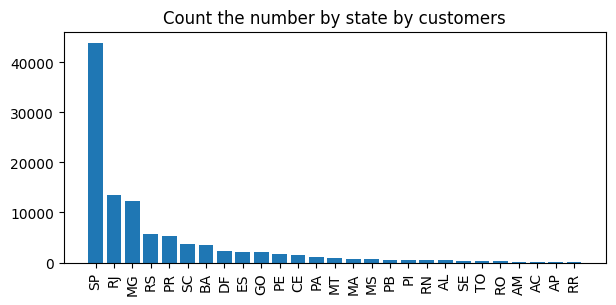

In [8]:
import matplotlib.pyplot as plt
counting2 = """ select customer_state,count(customer_id) as total_customers
from customers
group by customer_state """

cursor.execute(counting2)

val4 = cursor.fetchall()
val4
df=pd.DataFrame(val4,columns = ["state","customer_count"])
df=df.sort_values(by= "customer_count", ascending=False)
plt.figure(figsize=(7,3))
plt.bar(df["state"],df["customer_count"])
plt.title("Count the number by state by customers")
plt.xticks(rotation=90)
plt.show() 

# calculate the number of order per month in 2018

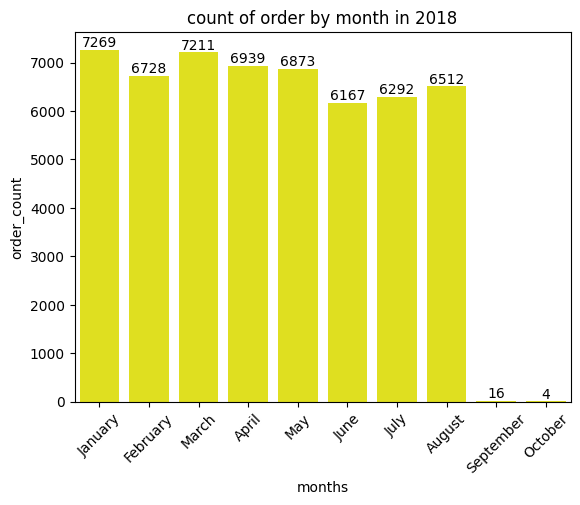

In [9]:
import seaborn as sns
calculate = """ select monthname(order_purchase_timestamp) as monthly,count(order_id) as customer_count
from orders
where year(order_purchase_timestamp)='2018'
group by monthly """

cursor.execute(calculate)
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])

o=["January","February","March","April","May","June","July","August","September","October"]

ab=sns.barplot(x=df["months"], y=df["order_count"],data=df ,order=o,color="yellow")
ab.bar_label(ab.containers[0])
plt.xticks(rotation=45)
plt.title("count of order by month in 2018")
plt.show()


# find the average number of products per order,grouped by customer city

In [10]:
counting = """ with mycte as(
select o.order_id as order_id,o.customer_id,count(ob.order_id) as total_order_count
from orders o
join order_items ob on o.order_id = ob.order_id
group by o.order_id,o.customer_id)
select c.customer_city,avg(mycte.total_order_count) as avg_order_count
from customers c 
join mycte on mycte.customer_id = c.customer_id
group by c.customer_city
"""

cursor.execute(counting)
val6=cursor.fetchall()
val6

[('sao paulo', Decimal('1.1554')),
 ('sao jose dos campos', Decimal('1.1351')),
 ('porto alegre', Decimal('1.1764')),
 ('indaial', Decimal('1.1481')),
 ('treze tilias', Decimal('1.2500')),
 ('rio de janeiro', Decimal('1.1487')),
 ('mario campos', Decimal('1.2500')),
 ('guariba', Decimal('1.0000')),
 ('cuiaba', Decimal('1.1863')),
 ('franca', Decimal('1.2515')),
 ('tocos', Decimal('1.0000')),
 ('januaria', Decimal('1.1600')),
 ('campinas', Decimal('1.1579')),
 ('embu-guacu', Decimal('1.2292')),
 ('cerquilho', Decimal('1.1714')),
 ('belo horizonte', Decimal('1.1417')),
 ('taubate', Decimal('1.1429')),
 ('arcos', Decimal('1.1154')),
 ('monte mor', Decimal('1.0732')),
 ('vianopolis', Decimal('1.2500')),
 ('cacapava', Decimal('1.1429')),
 ('sao jose da tapera', Decimal('1.0000')),
 ('belford roxo', Decimal('1.0847')),
 ('pedro leopoldo', Decimal('1.2889')),
 ('arroio do sal', Decimal('1.2500')),
 ('sao bernardo do campo', Decimal('1.1449')),
 ('brasilia', Decimal('1.1300')),
 ('ribeirao pir

# Calculate the percentage of total revenue contributed by each product category.

In [11]:
percentage= """ select p.product_category as category ,round(sum(pm.payment_value)/(select sum(payment_value) from payments)*100,2) as total_sales
from products p
join order_items o on p.product_id = o.product_id
join payments pm on pm.order_id=o.order_id
group by category """
cursor.execute(percentage)
val7 = cursor.fetchall()
val7


[('perfumery', 3.17),
 ('Furniture Decoration', 8.93),
 ('telephony', 3.04),
 ('bed table bath', 10.7),
 ('automotive', 5.32),
 ('computer accessories', 9.9),
 ('housewares', 6.84),
 ('babies', 3.37),
 ('toys', 3.87),
 ('Furniture office', 4.04),
 ('Cool Stuff', 4.87),
 ('HEALTH BEAUTY', 10.35),
 ('pet Shop', 1.94),
 ('General Interest Books', 0.4),
 ('stationary store', 1.98),
 ('Watches present', 8.93),
 ('PCs', 1.74),
 ('climatization', 0.57),
 ('Construction Tools Construction', 1.51),
 ('sport leisure', 8.7),
 ('Bags Accessories', 1.17),
 ('electronics', 1.62),
 ('Casa Construcao', 0.85),
 ('Games consoles', 1.22),
 ('Fashion Bags and Accessories', 1.36),
 ('home appliances', 0.6),
 ('Garden tools', 5.24),
 ('Agro Industria e Comercio', 0.74),
 (None, 1.58),
 ('audio', 0.38),
 ('technical books', 0.16),
 ('Construction Tools Garden', 0.26),
 ('Market Place', 0.28),
 ('musical instruments', 1.46),
 ('Drink foods', 0.17),
 ('SIGNALIZATION AND SAFETY', 0.43),
 ('Furniture Kitchen Ser

# Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
import numpy as np
query= """ select p.product_category,count(o.product_id)as count_number_of_orders,
round(avg(o.price),2)
from products p 
join order_items o 
on p.product_id = o.product_id
group by p.product_category """
cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data,columns=["category","order_count","price"])

arr1=df["order_count"]
arr2=df["price"]

np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

In [13]:
query= """ select * ,dense_rank() over (order by revenue desc) as rnk from 
(select
o.seller_id,round(sum(p.payment_value),2)as revenue
from payments p
join order_items o
on p.order_id=o.order_id
group by o.seller_id) as ab """

cursor.execute(query)
data =  cursor.fetchall()
data

[('7c67e1448b00f6e969d365cea6b010ab', 507166.91, 1),
 ('1025f0e2d44d7041d6cf58b6550e0bfa', 308222.04, 2),
 ('4a3ca9315b744ce9f8e9374361493884', 301245.27, 3),
 ('1f50f920176fa81dab994f9023523100', 290253.42, 4),
 ('53243585a1d6dc2643021fd1853d8905', 284903.08, 5),
 ('da8622b14eb17ae2831f4ac5b9dab84a', 272219.32, 6),
 ('4869f7a5dfa277a7dca6462dcf3b52b2', 264166.12, 7),
 ('955fee9216a65b617aa5c0531780ce60', 236322.3, 8),
 ('fa1c13f2614d7b5c4749cbc52fecda94', 206513.23, 9),
 ('7e93a43ef30c4f03f38b393420bc753a', 185134.21, 10),
 ('6560211a19b47992c3666cc44a7e94c0', 179657.75, 11),
 ('7a67c85e85bb2ce8582c35f2203ad736', 169030.8, 12),
 ('25c5c91f63607446a97b143d2d535d31', 160534.74, 13),
 ('a1043bafd471dff536d0c462352beb48', 154356.91, 14),
 ('46dc3b2cc0980fb8ec44634e21d2718e', 148864.34, 15),
 ('b37c4c02bda3161a7546a4e6d222d5b2', 145319.04, 16),
 ('620c87c171fb2a6dd6e8bb4dec959fc6', 145267.95, 17),
 ('cc419e0650a3c5ba77189a1882b7556a', 141309.58, 18),
 ('5dceca129747e92ff8ef7a997dc4f8ca', 1

# Calculate the moving average of order values for each customer over their order history.

In [14]:
query = """ select customer_id ,order_purchase_timestamp ,
avg(payment) over (partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as moving_avg
from
(select o.customer_id,o.order_purchase_timestamp,p.payment_value as payment
from orders o
join payments p
on o.order_id = p.order_id) as ab """

cursor.execute(query)
data = cursor. fetchall()
data

[('00012a2ce6f8dcda20d059ce98491703',
  '2017-11-14 16:08:26',
  114.73999786376953),
 ('000161a058600d5901f007fab4c27140',
  '2017-07-16 09:40:32',
  67.41000366210938),
 ('0001fd6190edaaf884bcaf3d49edf079',
  '2017-02-28 11:06:43',
  195.4199981689453),
 ('0002414f95344307404f0ace7a26f1d5',
  '2017-08-16 13:09:20',
  179.35000610351562),
 ('000379cdec625522490c315e70c7a9fb',
  '2018-04-02 13:42:17',
  107.01000213623047),
 ('0004164d20a9e969af783496f3408652',
  '2017-04-12 08:35:12',
  71.80000305175781),
 ('000419c5494106c306a97b5635748086',
  '2018-03-02 17:47:40',
  49.400001525878906),
 ('00046a560d407e99b969756e0b10f282',
  '2017-12-18 11:08:30',
  166.58999633789062),
 ('00050bf6e01e69d5c0fd612f1bcfb69c', '2017-09-17 16:04:44', 85.2300033569336),
 ('000598caf2ef4117407665ac33275130', '2018-08-11 12:14:35', 1255.7099609375),
 ('0005aefbb696d34b3424dccd0a0e9fd0',
  '2018-06-20 09:46:53',
  147.3300018310547),
 ('00062b33cb9f6fe976afdcff967ea74d',
  '2017-03-15 23:44:09',
  58.950